In [1]:
import os
import librosa
from librosa.feature import melspectrogram
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from PIL import Image
from tqdm import tqdm
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, classification_report

import torch
import torchvision
from torchvision.models import ResNet50_Weights, VGG16_Weights, DenseNet121_Weights
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.models as models
from torchvision.transforms import v2
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import KFold

# Hyperparameters

In [2]:
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
SAMPLE_DURATION = 15
RESIZE = 224

In [3]:
AUDIO_DIR = 'audio/'
SPECTROGRAM_DIR = f'spectrogram_224_{SAMPLE_DURATION}s/'
ANNOTATIONS_FILE = 'annotations.csv'
NUM_CLASSES = 4
EMOTION_CLASSES = ['Happy', 'Calm', 'Angry', 'Sad']
EMOTION_MAP = {
        0: 'Happy',
        1: 'Calm',
        2: 'Angry',
        3: 'Sad'
    }

# Utilities

In [4]:
def get_melsp(y, sr, resize, start_time, duration):
    """
    Generates a Mel-spectrogram image from a segment of an audio signal and normalizes it.
    
    Args:
        y (np.ndarray): Audio time-series data.
        sr (int): Sampling rate of the audio.
        resize (int): Size to resize the spectrogram image.
        start_time (float): Start time of the segment in seconds.
        duration (float): Duration of the segment in seconds.
    
    Returns:
        PIL.Image.Image: Image object of the Mel-spectrogram normalized and resized.
    """
    
    start_sample = int(start_time * sr)
    end_sample = start_sample + int(duration * sr)
    y_segment = y[start_sample:end_sample]
    
    mel_spect = librosa.feature.melspectrogram(y=y_segment, sr=sr, 
                                               n_mels=N_MELS, 
                                               n_fft=N_FFT,
                                               hop_length=HOP_LENGTH)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
    mel_spect_db = (mel_spect_db - mel_spect_db.min()) / (mel_spect_db.max() - mel_spect_db.min())
    
    return Image.fromarray(mel_spect_db * 255).convert('L').resize((resize, resize), Image.LANCZOS)

In [5]:
def map_arousal_valence_to_emotion(arousal, valence):
    """
    Maps arousal and valence values to discrete emotion classes.
    
    Args:
        arousal (float): Arousal value scaled from 1 to 9.
        valence (float): Valence value scaled from 1 to 9.
    
    Returns:
        int: Integer label corresponding to an emotion class.
            - 0: Happy
            - 1: Calm
            - 2: Angry
            - 3: Sad
            - -1: Undefined (if values do not fall into any defined range)
    """
    if 5 <= valence <= 9:
        if 5 <= arousal <= 9:
            return 0  # Happy
        elif 1 <= arousal < 5:
            return 1  # Calm
    elif 1 <= valence <= 5:
        if 5 <= arousal <= 9:
            return 2  # Angry
        elif 1 <= arousal < 5:
            return 3  # Sad
    
    return -1  # Undefined

In [6]:
def grayscale_to_rgb(image):
    return Image.merge("RGB", (image, image, image))

In [7]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [27]:
class EmotionClassificationTrainer:
    def __init__(self, dataset, model_class, criterion_class, optimizer_class, scheduler_class, 
                 device, batch_size, learning_rate, num_classes=4, k_folds=5, epochs=20, patience=5, class_weights=None):
        self.dataset = dataset
        self.model_class = model_class
        self.criterion_class = criterion_class
        self.optimizer_class = optimizer_class
        self.scheduler_class = scheduler_class
        self.device = device
        self.num_classes = num_classes
        self.k_folds = k_folds
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.learning_rate = learning_rate
        self.class_weights = class_weights

        self.train_losses, self.train_accuracies = [], []
        self.test_losses, self.test_accuracies = [], []
        self.all_true_labels, self.all_predicted_labels = [], []

    def reset_model(self):
        model = self.model_class(self.num_classes).to(self.device)
        criterion = self.criterion_class(weight=self.class_weights)
        optimizer = self.optimizer_class(model.parameters(), lr=self.learning_rate)
        scheduler = self.scheduler_class(optimizer, step_size=5, gamma=0.1)
        return model, criterion, optimizer, scheduler

    def train_and_test(self, model, train_dataloader, test_dataloader, criterion, optimizer, scheduler):
        best_test_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            pbar_train = tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}/{self.epochs}', unit='batch')

            for images, labels in pbar_train:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = model(images)

                # Calculate loss
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                pbar_train.set_postfix({'Loss': running_loss / (total if total > 0 else 1), 'Accuracy': 100. * correct / total})

            # Calculate average training loss and accuracy for the epoch
            epoch_train_loss = running_loss / len(train_dataloader)
            epoch_train_accuracy = 100. * correct / total

            # Append to lists
            self.train_losses.append(epoch_train_loss)
            self.train_accuracies.append(epoch_train_accuracy)

            # Print epoch summary after completing training phase
            print(f'Epoch {epoch+1}, Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.2f}%')

            torch.cuda.empty_cache()

            scheduler.step()

            # Test phase (early stopping evaluation)
            model.eval()
            test_loss = 0.0
            correct = 0
            total = 0

            pbar_test = tqdm(test_dataloader, desc=f'Test Epoch {epoch+1}/{self.epochs}', unit='batch', leave=False)

            with torch.no_grad():
                for images, labels in pbar_test:
                    images, labels = images.to(self.device), labels.to(self.device)
                    outputs = model(images)

                    # Calculate loss
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()

                    # Calculate accuracy
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    # Collect true and predicted labels
                    self.all_true_labels.extend(labels.cpu().numpy())
                    self.all_predicted_labels.extend(predicted.cpu().numpy())

                    pbar_test.set_postfix({'Loss': test_loss / (total if total > 0 else 1), 'Accuracy': 100. * correct / total})

            # Calculate average Test loss and accuracy for the epoch
            epoch_test_loss = test_loss / len(test_dataloader)
            epoch_test_accuracy = 100. * correct / total

            # Append to lists
            self.test_losses.append(epoch_test_loss)
            self.test_accuracies.append(epoch_test_accuracy)

            # Print epoch summary after completing Test phase
            print(f'Epoch {epoch+1}, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.2f}%')

            # Check for early stopping
            if epoch_test_loss < best_test_loss:
                best_test_loss = epoch_test_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    print(f'Early stopping triggered after {epoch+1} epochs')
                    break

        # Calculate precision, recall, and F1-score at the end
        final_precision = precision_score(self.all_true_labels, self.all_predicted_labels, average='weighted')
        final_recall = recall_score(self.all_true_labels, self.all_predicted_labels, average='weighted')
        final_f1_score = f1_score(self.all_true_labels, self.all_predicted_labels, average='weighted')

        print(f'Final Precision: {final_precision:.4f}, Final Recall: {final_recall:.4f}, Final F1-Score: {final_f1_score:.4f}')

        self.plot_confusion_matrix()
        self.generate_classification_report()

    def k_fold_cross_test(self):
        if self.k_folds == 1:
            # Single Train-Test Split
            print('Single Train-Test Split')
            train_size = int(0.8 * len(self.dataset))
            indices = torch.randperm(len(self.dataset)).tolist()
            train_indices, test_indices = indices[:train_size], indices[train_size:]

            train_subset = Subset(self.dataset, train_indices)
            test_subset = Subset(self.dataset, test_indices)

            train_dataloader = DataLoader(train_subset, batch_size=self.batch_size, shuffle=True)
            test_dataloader = DataLoader(test_subset, batch_size=self.batch_size, shuffle=False)

            model, criterion, optimizer, scheduler = self.reset_model()
            self.train_and_test(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler)

        else:
            # K-Fold Cross-Validation
            kf = KFold(n_splits=self.k_folds, shuffle=True)
            fold_results = []

            for fold, (train_idx, test_idx) in enumerate(kf.split(self.dataset)):
                print(f'Fold {fold+1}/{self.k_folds}')

                train_subset = Subset(self.dataset, train_idx)
                test_subset = Subset(self.dataset, test_idx)

                train_dataloader = DataLoader(train_subset, batch_size=self.batch_size, shuffle=True)
                test_dataloader = DataLoader(test_subset, batch_size=self.batch_size, shuffle=False)

                model, criterion, optimizer, scheduler = self.reset_model()

                self.train_and_test(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler)

                fold_results.append({
                    'train_losses': self.train_losses,
                    'train_accuracies': self.train_accuracies,
                    'test_losses': self.test_losses,
                    'test_accuracies': self.test_accuracies
                })

            return fold_results

    def visualize_results(self, fold_results):
        if self.k_folds == 1:
            # Single train-test split case
            plt.figure(figsize=(10, 4))
    
            plt.subplot(1, 2, 1)
            plt.plot(self.train_losses, label='Train Loss')
            plt.plot(self.test_losses, label='Test Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Test Loss')
            plt.legend()
    
            plt.subplot(1, 2, 2)
            plt.plot(self.train_accuracies, label='Train Accuracy')
            plt.plot(self.test_accuracies, label='Test Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title('Training and Test Accuracy')
            plt.legend()
    
            plt.tight_layout()
            plt.show()
        
        else:
            # K-Fold Cross-Validation case
            for fold, result in enumerate(fold_results):
                plt.figure(figsize=(10, 4))
                
                plt.subplot(1, 2, 1)
                plt.plot(result['train_losses'], label=f'Train Loss Fold {fold+1}')
                plt.plot(result['test_losses'], label=f'Test Loss Fold {fold+1}')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title(f'Fold {fold+1} Training and Test Loss')
                plt.legend()
                
                plt.subplot(1, 2, 2)
                plt.plot(result['train_accuracies'], label=f'Train Accuracy Fold {fold+1}')
                plt.plot(result['test_accuracies'], label=f'Test Accuracy Fold {fold+1}')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.title(f'Fold {fold+1} Training and Test Accuracy')
                plt.legend()
    
                plt.tight_layout()
                plt.show()

    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.all_true_labels, self.all_predicted_labels)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=['Happy', 'Calm', 'Angry', 'Sad'], 
                    yticklabels=['Happy', 'Calm', 'Angry', 'Sad'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    def generate_classification_report(self):
        print(f"Final test accuracy: {self.test_accuracies[-1]:.2f}%")
        print(classification_report(self.all_true_labels, self.all_predicted_labels, target_names=['Happy', 'Calm', 'Angry', 'Sad']))


# Get Data

In [9]:
# Convert audio to mel-spectrogram and save in SPECTROGRAM_DIR
if not os.path.exists(SPECTROGRAM_DIR):
    os.makedirs(SPECTROGRAM_DIR)
    print(f'Created directory: {SPECTROGRAM_DIR}')
    print('Processing audio files...')
    for filename in os.listdir(AUDIO_DIR):
        if filename.endswith('.mp3'):
            audio_path = os.path.join(AUDIO_DIR, filename)
            y, sr = librosa.load(audio_path, sr=None)
            
            # Split into 5-second segments and process each
            total_duration = librosa.get_duration(y=y, sr=sr)
            num_segments = int(total_duration // SAMPLE_DURATION)
            
            for i in range(num_segments):
                start_time = i * SAMPLE_DURATION
                spectrogram_filename = f'{os.path.splitext(filename)[0]}_segment_{i}.png'
                spectrogram_path = os.path.join(SPECTROGRAM_DIR, spectrogram_filename)
                
                mel_spect_img = get_melsp(y, sr, RESIZE, start_time, SAMPLE_DURATION)
                mel_spect_img.save(spectrogram_path)

print('Finished processing audio files.')

Finished processing audio files.


In [10]:
class SpectrogramDataset(Dataset):
    EMOTION_MAP = {
        0: 'Happy',
        1: 'Calm',
        2: 'Angry',
        3: 'Sad'
    }
    
    def __init__(self, spectrogram_dir, annotations, transform=None):
        self.spectrogram_dir = spectrogram_dir
        self.annotations = annotations
        self.labels = annotations[[' valence_mean', ' arousal_mean']].to_numpy().astype(np.float32)
        self.transform = transform

        # Calculate emotion labels and append as a new column
        self.annotations['emotion_label'] = self.annotations.apply(
            lambda row: map_arousal_valence_to_emotion(row[' arousal_mean'], row[' valence_mean']),
            axis=1
        )

        # Expand annotations to include segment information
        self.segmented_annotations = []
        for idx, row in self.annotations.iterrows():
            song_id = int(row['song_id'])
            emotion_label = int(row['emotion_label'])
            for segment in range(int(45/SAMPLE_DURATION)):
                img_path = os.path.join(self.spectrogram_dir, f'{song_id}_segment_{segment}.png')
                if os.path.exists(img_path):
                    self.segmented_annotations.append((song_id, segment, emotion_label))


    def __len__(self):
        return len(self.segmented_annotations)

    def __getitem__(self, idx):
        song_id, segment, emotion_label = self.segmented_annotations[idx]
        img_path = os.path.join(self.spectrogram_dir, f'{song_id}_segment_{segment}.png')

        # Load image
        image = Image.open(img_path).convert('L')
        image = grayscale_to_rgb(image)

        if self.transform:
            image = self.transform(image)

        return image, emotion_label


In [11]:
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [12]:
annotations = pd.read_csv(ANNOTATIONS_FILE)
dataset = SpectrogramDataset(SPECTROGRAM_DIR, annotations, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f'Size of train dataset: {train_size}\nSize of test dataset: {test_size}')

Size of train dataset: 4178
Size of test dataset: 1045


# EDA

In [13]:
df = pd.DataFrame(dataset.segmented_annotations, columns=['song_id', 'segment', 'emotion_label'])

In [14]:
df.head()

,song_id,segment,emotion_label
0,2,0,3
1,2,1,3
2,2,2,3
3,3,0,3
4,3,1,3


In [15]:
df['emotion_label'].value_counts()

emotion_label
3    2010
0    1899
1     666
2     648
Name: count, dtype: int64

In [16]:
def plot_valence_arousal_distribution(df):
    plt.figure(figsize=(9, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[' valence_mean'], kde=True, bins=30)
    plt.title('Distribution of Valence Mean')
    plt.xlabel('Valence Mean')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(df[' arousal_mean'], kde=True, bins=30)
    plt.title('Distribution of Arousal Mean')
    plt.xlabel('Arousal Mean')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def scatter_valence_arousal(df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=' valence_mean', y=' arousal_mean', hue='emotion_label', data=df, palette='tab10')
    plt.title('Scatter Plot of Valence vs Arousal')
    plt.xlabel('Valence Mean')
    plt.ylabel('Arousal Mean')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.show()

def barplot_emotion_counts(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='emotion_label', hue='emotion_label', data=df, palette='tab10', order=df['emotion_label'].value_counts().index, legend=False)
    plt.title('Counts of Each Emotion Label')
    plt.xlabel('Emotion Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

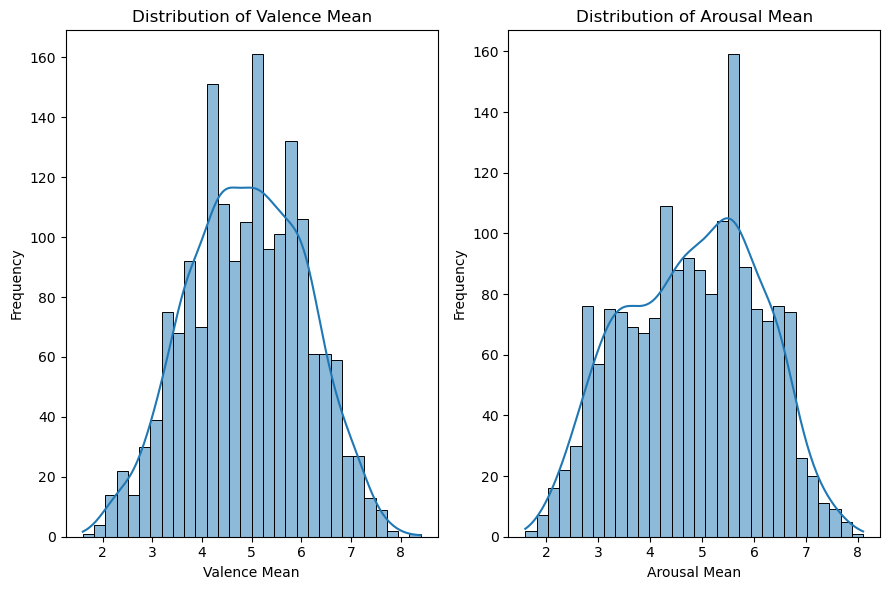

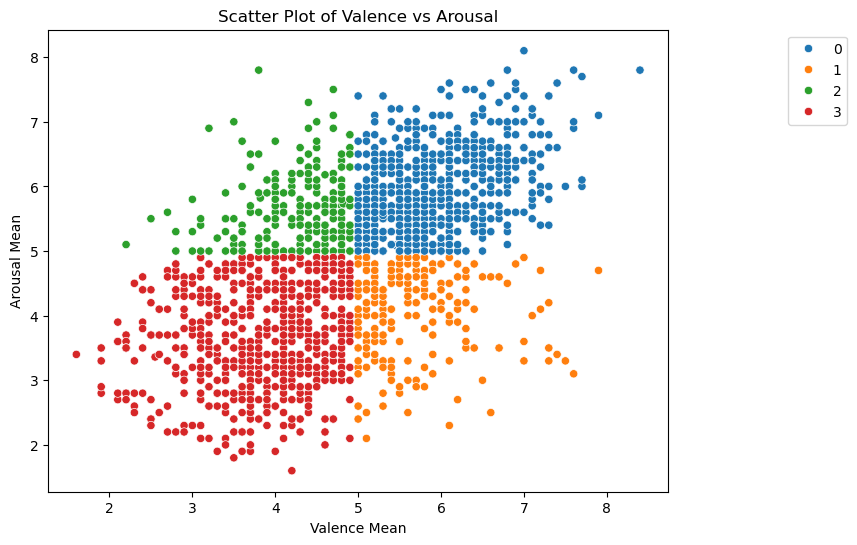

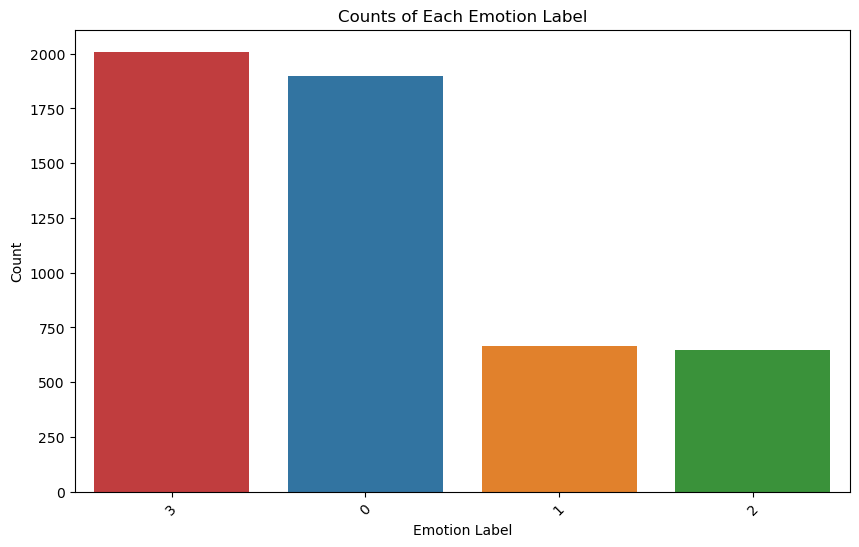

In [18]:
plot_valence_arousal_distribution(annotations)
scatter_valence_arousal(annotations)
barplot_emotion_counts(df)

# Define Models

In [19]:
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [20]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
        num_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.vgg16(x)

In [21]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.densenet = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.densenet(x)

In [22]:
class StackingEnsemble(nn.Module):
    def __init__(self, num_classes):
        super(StackingEnsemble, self).__init__()
        self.resnet50 = ResNet50(num_classes)
        self.vgg16 = VGG16(num_classes)
        self.densenet121 = DenseNet121(num_classes)
        combined_features = num_classes * 3 # 3 models
        self.meta_classifier = nn.Linear(combined_features, num_classes)

    def forward(self, x):
        resnet_out = self.resnet50(x)
        vgg_out = self.vgg16(x)
        densenet_out = self.densenet121(x)
        combined = torch.cat((resnet_out, vgg_out, densenet_out), dim=1)
        return self.meta_classifier(combined)

# Train and Test Models

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
df['emotion_label'].value_counts()

emotion_label
3    2010
0    1899
1     666
2     648
Name: count, dtype: int64

In [26]:
# Manual input 
class_counts = {'Happy': 1899, 'Calm': 666, 'Angry': 648, 'Sad': 2010}
total_samples = sum(class_counts.values())
class_weights = [total_samples / (len(class_counts) * count) for count in class_counts.values()]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
class_weights

tensor([0.6876, 1.9606, 2.0150, 0.6496], device='cuda:0')

## ResNet50

In [ ]:
set_seed(616)
v1_rn_model = EmotionClassificationTrainer(dataset=dataset, 
                                           model_class=ResNet50, 
                                           criterion_class=nn.CrossEntropyLoss, 
                                           optimizer_class=optim.Adam, 
                                           scheduler_class=StepLR, 
                                           device=device,
                                           batch_size=8,
                                           learning_rate=0.001,
                                           k_folds=1,
                                           class_weights=class_weights)

In [ ]:
v1_rn_results = v1_rn_model.k_fold_cross_test()

In [ ]:
v1_rn_model.visualize_results(v1_rn_results)

## VGG16

## DenseNet121